The notebook contains price modelling procedure as well as setting different price strategies for use in contextual bandits. 

<a id="0">Content:</a> <br>
1. [Demand function modelling](#df)  
1. [Price optimisation](#po)


I used two staged price modelling procedure for each SKU:

 - based on historical data I tried to estimate a demand function: $d(price, \theta)$, where $\theta$ -other features 
 
 - tried to fined an optimal price for each week of the target period by solving a profit optimisation problem: $p\cdot d(p, \theta) \to \max_{p}$

In [ ]:
import pandas as pd
import numpy as np

import datetime

import copy
import json
import pickle

from tqdm import tqdm

import seaborn as sns
from matplotlib import pyplot as plt
sns.set_theme("paper")

In [2]:
import sys
sys.path.append('..')

from lib.data import get_data, get_sales_plan, get_price_diff

PATH = '/Users/andreichekunov/andrei/hard_ml/dynamic pricing/final project dynamic pricing/data/'
PATH_ARTEFACTS = '../artefacts/'

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
transactions, daily = get_data(mode='daily')
daily.dates = pd.to_datetime(daily.dates)

daily = daily[daily.actual]

with open(PATH_ARTEFACTS + '/sku_classes.json', 'r') as json_file:
    sku_classes = json.load(json_file)
    
assert daily.groupby(['SKU', 'dates']).year.count().max() == 1

In [5]:
sales_plan = pd.read_csv(PATH + 'sales_plan.csv')
sales_plan.head()

,SKU,year,month,plan,back_bonus
0,10290,2018,2,20.0,120000
1,10290,2018,3,60.0,140000
2,10290,2018,4,70.0,140000
3,10290,2018,5,60.0,140000
4,10290,2018,6,60.0,40000


# <a id="df">Demand function modelling</a>

In [6]:
from statsmodels.tsa.arima.model import ARIMA
import catboost
from ipywidgets import IntSlider
display(IntSlider())

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, QuantileRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy.interpolate import make_interp_spline

IntSlider(value=0)

### phase 1: base demand

From the visual analysis (EDA notebook) it can be seen, that there are two kinds of dynamics in sales: clear seasonal waves and strange peaks of not the clear nature. The target period is the December of 2019 and many time series have too short history and could not be modelled with help of models with year seasonality. Because of it, I tried to toransfer the averaged sales structure for each time series class of historical SKU sales, I determined in the EDA notebook. For each classes the sales structures for 2018 and 2019 are not identical, but it catchs the most part of all changes. I used the following procedure for each class:

 - Averaging standardised 2018 tails of time series with 2018 history
 - Daily transferring of the 2018 structure to 2019 in form of two features: a dummy for peaks, smother and clipped structure

After that I trained a Catboost model for each class of time series. 

In [282]:
def get_base_sales_structure(df, class_):
    df_base = df[(df.year==2018)&(df.SKU.isin(sku_classes[class_]))]
    df_work = df[(df.year==2019)&(df.SKU.isin(sku_classes[class_]))]
    all_ts = df_base.loc[:, ['SKU', 'dates', 'sales']].pivot_table(index='dates',
                                                                   columns='SKU',
                                                                   values='sales')
    for i, sku in enumerate(all_ts.columns):
        #all_ts.loc[:, sku] = all_ts.loc[:, sku].ffill()
        #all_ts.loc[:, sku] = all_ts.loc[:, sku].ewm(com=0.5).mean()
        all_ts.loc[:, sku] = all_ts.loc[:, sku]
    scaler = StandardScaler() 
    all_ts.loc[:, :] = scaler.fit_transform(all_ts)

    structure = all_ts.mean(axis=1).reset_index()
    structure.columns = ['dates', 'demand_structure']
    structure['demand_structure_smoothed'] = structure['demand_structure'].rolling(7, center=True).mean()
    structure['demand_structure_smoothed'] = structure['demand_structure_smoothed'].fillna(method='ffill')
    # used features:
    structure['demand_structure_smoothed'] = structure['demand_structure_smoothed'].map(lambda x: min(x, 0.3))
    structure['advertising?'] = structure['demand_structure'].map(lambda x: 1 if x > 0.8 else 0)
    
    structure['dates'] = structure['dates'] + np.timedelta64(365,'D')
    
    df_work = df_work.merge(structure, on='dates', how='left')
    return all_ts, df_work

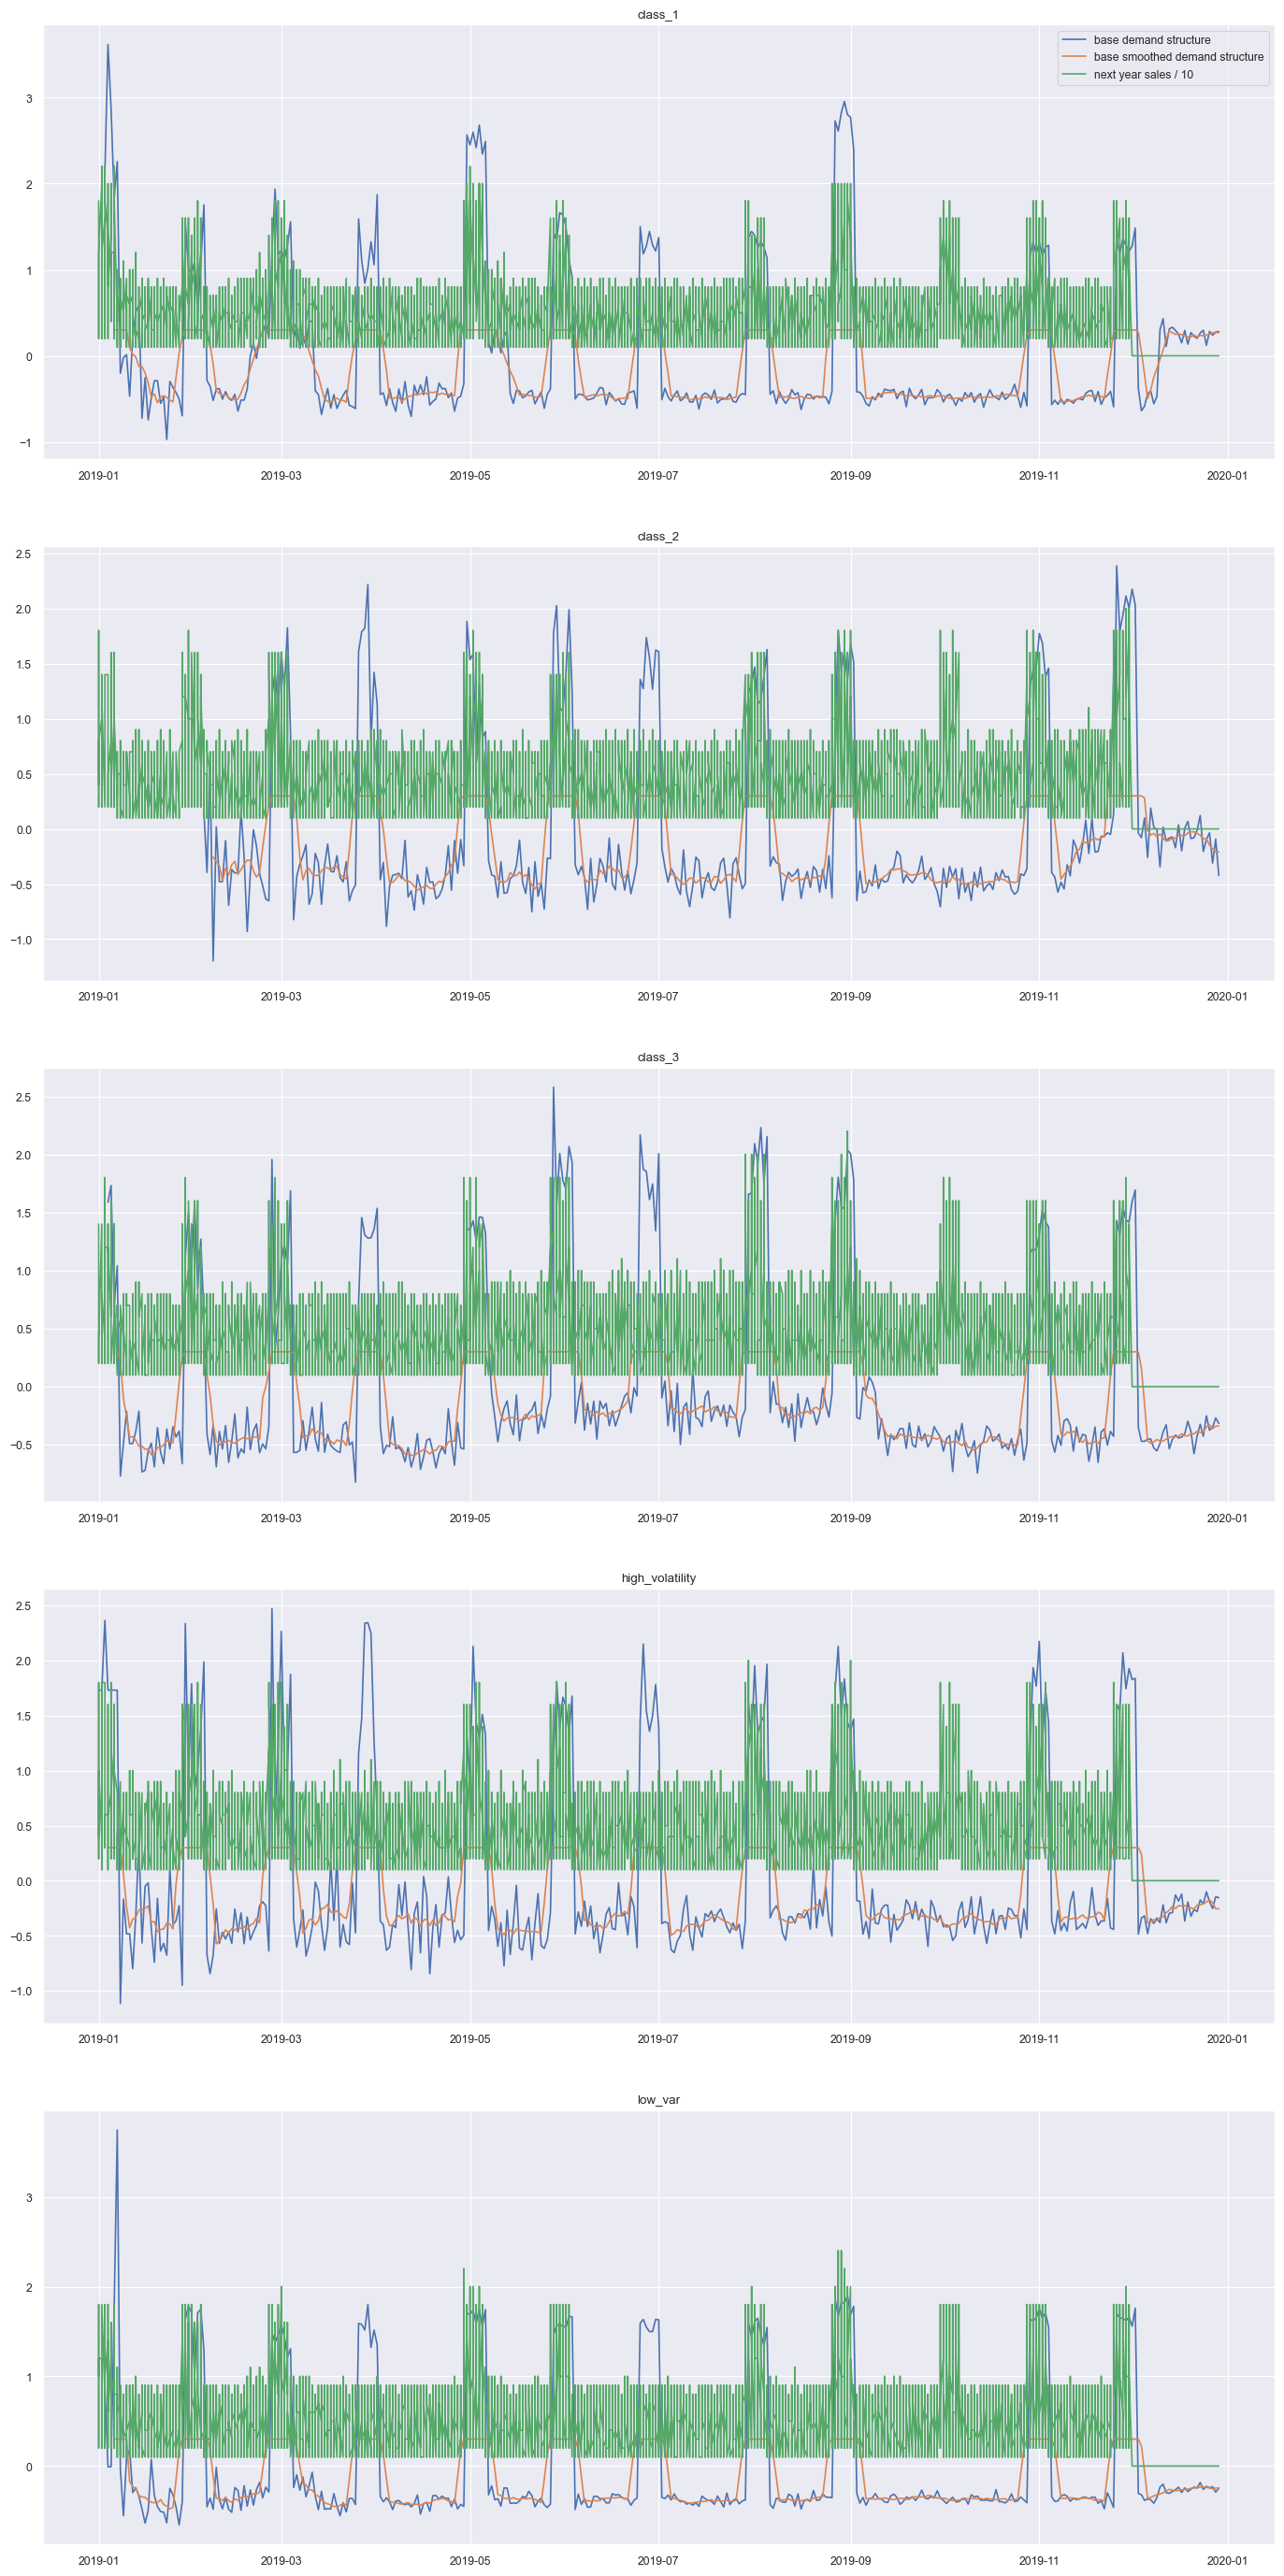

In [288]:
n = 5
fig, ax = plt.subplots(n, 1, figsize=(17, 7*n))
demand_structure = []
for i, class_ in enumerate(sku_classes.keys()):
    all_ts, df_work = get_base_sales_structure(daily, class_)
    demand_structure.append(df_work)
    ax[i].plot(df_work.dates.values, df_work.demand_structure.values, label='base demand structure')
    ax[i].plot(df_work.dates.values, df_work.demand_structure_smoothed.values, label='base smoothed demand structure')
    ax[i].plot(df_work.dates.values, df_work.sales.values/10,  label='next year sales / 10')
    ax[i].set_title(class_)
    if i == 0:
        ax[0].legend()

In [289]:
df_work = pd.concat(demand_structure)
df_work['marg'] = df_work['price_avg'] - df_work['cost_price']
df_work['avg_price_ratio'] = df_work['price_avg']/df_work['cost_price']

daily_pred = df_work[df_work.dates > np.datetime64('2019-11-24')].reset_index(drop=True)
daily_pred['week_num'] = daily_pred['week_num'] + 52*(daily_pred['year']-2018)

daily_data = df_work[df_work.dates <= np.datetime64('2019-11-30')].reset_index(drop=True)
daily_data = get_price_diff(daily_data)

###  phase 2: demand = f(base demand, price, other parameters) 

In [62]:
def my_train_test_split(df_, class_sku, test=(2019, 11)):
    df = df_[df_.SKU.isin(class_sku)]
    df = df.sort_values('dates')
    for sku in df.SKU.unique():
        ii = df[df.SKU==sku].index
        #df.loc[ii, 'sales'] = df.loc[ii, 'sales'].rolling(3).mean()
    #df = df.dropna()
    df_train = df[~((df.year==test[0])&(df.month==test[1]))]
    df_test = df[(df.year==test[0])&(df.month==test[1])]
    return df_train, df_test

models = {}
features = {}
models_full = {}

In [84]:
daily_data.columns
columns = ['SKU', 'dates', 'year', 'month', 'ui3_plan', 
 'weekday', 'discount', 'day', 'week', 'sales',
           'cost_price', 'min_comp_price', 'marg', 
       'ui2_code', 'ui3_code', 'brand_code', 'ui2_sales',
       'ui3_sales', 'plan', 'ui1_plan', 'ui2_plan',  
       'ui1_plan_delta', 'ui2_plan_delta', 'ui3_plan_delta', 'plan_per_day',
       'holidays', 'summer', 'end_of_year', 'monthlength',
           'advertising?', 'price_avg', 
           'demand_structure', 'demand_structure_smoothed', 
           'price_diff', 'price_week_diff', 'avg_price_ratio'
          ]

daily_data.loc[:, columns].dropna().shape, daily_data.shape

((192898, 36), (202711, 41))

In [85]:
sku_classes.keys()

dict_keys(['class_1', 'class_2', 'class_3', 'high_volatility', 'low_var'])

In [178]:
class_ = 'low_var'
train_df, val_df = my_train_test_split(daily_data.loc[:, columns].dropna(), sku_classes[class_])
train_df_full = daily_data[daily_data.SKU.isin(sku_classes[class_])].dropna()

In [185]:
num_features = ['plan',
                #'discount', 
                #'marg', 
                #'min_comp_price', 
                #'holidays',
                'demand_structure_smoothed',
                'advertising?', 
                'cost_price',
                'price_avg', 
                'price_diff', 
                'price_week_diff',
                #'avg_price_ratio',
                #'summer', 
               ]
cat_features = ['SKU',
                'weekday', 'brand_code', 
               ]

In [186]:
train_data = catboost.Pool(train_df.loc[:, num_features + cat_features],
    label = train_df.sales,
    cat_features=cat_features,   
)

eval_data = catboost.Pool(val_df.loc[:, num_features + cat_features],
    label = val_df.sales,
    cat_features=cat_features,   
)

models[class_] = catboost.CatBoostRegressor(
                                   learning_rate=0.005,
                                   n_estimators=15000,
                                   random_state=1,
                                   early_stopping_rounds=100,
                                   verbose=True)
models[class_].fit(train_data, eval_set=eval_data, plot=False, verbose_eval=100)
features[class_] = num_features + cat_features

n = models[class_].get_best_iteration()
models_full[class_] = catboost.CatBoostRegressor(
                                   learning_rate=0.005,
                                   n_estimators=n,
                                   random_state=1,
                                   verbose=False)

train_data = catboost.Pool(train_df_full.loc[:, num_features + cat_features],
    label = train_df_full.sales,
    cat_features=cat_features,   
)
models_full[class_].fit(train_data)

0:	learn: 2.8331947	test: 3.1890196	best: 3.1890196 (0)	total: 18.1ms	remaining: 4m 31s
100:	learn: 2.2169442	test: 2.4475596	best: 2.4475596 (100)	total: 1.38s	remaining: 3m 23s
200:	learn: 1.9029132	test: 2.0215492	best: 2.0215492 (200)	total: 3.07s	remaining: 3m 46s
300:	learn: 1.7461517	test: 1.7699869	best: 1.7699869 (300)	total: 4.57s	remaining: 3m 43s
400:	learn: 1.6673994	test: 1.6294096	best: 1.6294096 (400)	total: 6.07s	remaining: 3m 41s
500:	learn: 1.6111147	test: 1.5488456	best: 1.5488456 (500)	total: 7.37s	remaining: 3m 33s
600:	learn: 1.5695978	test: 1.5051884	best: 1.5051884 (600)	total: 8.78s	remaining: 3m 30s
700:	learn: 1.5420634	test: 1.4755963	best: 1.4755963 (700)	total: 10.1s	remaining: 3m 27s
800:	learn: 1.5223515	test: 1.4576200	best: 1.4576200 (800)	total: 11.5s	remaining: 3m 23s
900:	learn: 1.5066860	test: 1.4465113	best: 1.4465113 (900)	total: 12.8s	remaining: 3m 20s
1000:	learn: 1.4921177	test: 1.4416990	best: 1.4416990 (1000)	total: 14.2s	remaining: 3m 18s


Text(0.5, 1.0, 'Feature Importance: class_1')

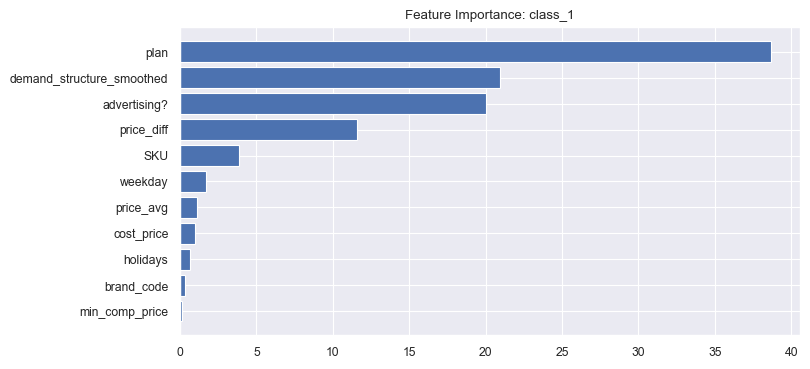

In [106]:
feature_importance = models[class_].feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(8, 4))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(num_features + cat_features)[sorted_idx])
plt.title(f'Feature Importance: {class_}')

Text(0.5, 1.0, 'Feature Importance: class_2')

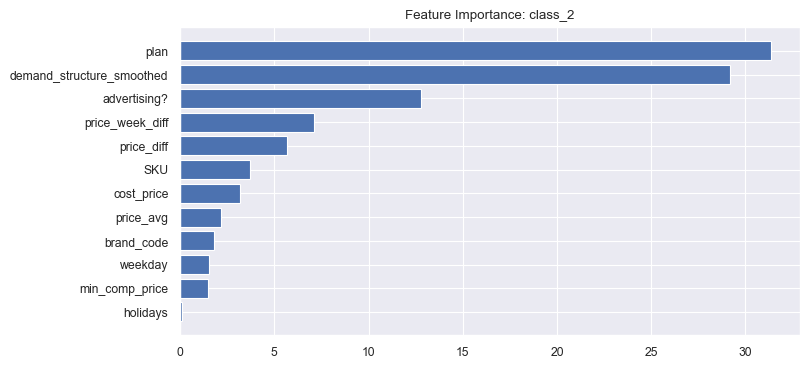

In [123]:
feature_importance = models[class_].feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(8, 4))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(num_features + cat_features)[sorted_idx])
plt.title(f'Feature Importance: {class_}')

Text(0.5, 1.0, 'Feature Importance: class_3')

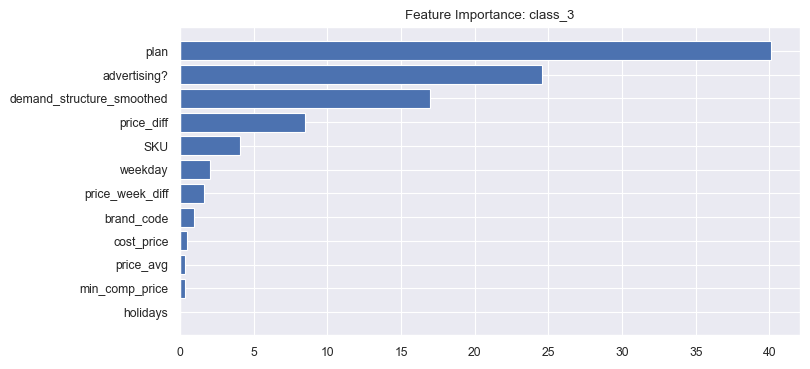

In [139]:
feature_importance = models[class_].feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(8, 4))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(num_features + cat_features)[sorted_idx])
plt.title(f'Feature Importance: {class_}')

Text(0.5, 1.0, 'Feature Importance: high_volatility')

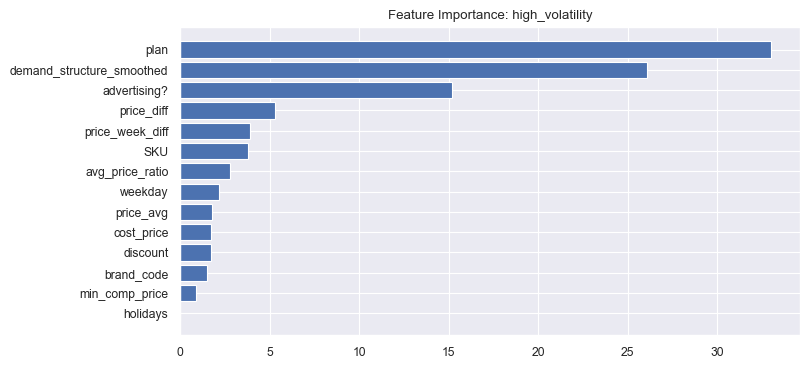

In [151]:
feature_importance = models[class_].feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(8, 4))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(num_features + cat_features)[sorted_idx])
plt.title(f'Feature Importance: {class_}')

Text(0.5, 1.0, 'Feature Importance: low_var')

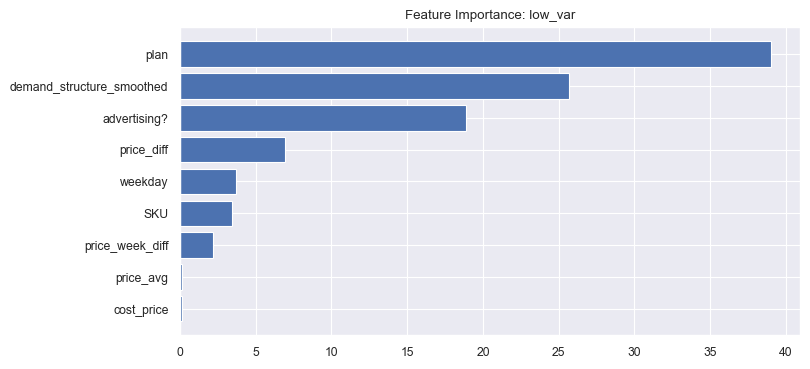

In [184]:
feature_importance = models[class_].feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(8, 4))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(num_features + cat_features)[sorted_idx])
plt.title(f'Feature Importance: {class_}')

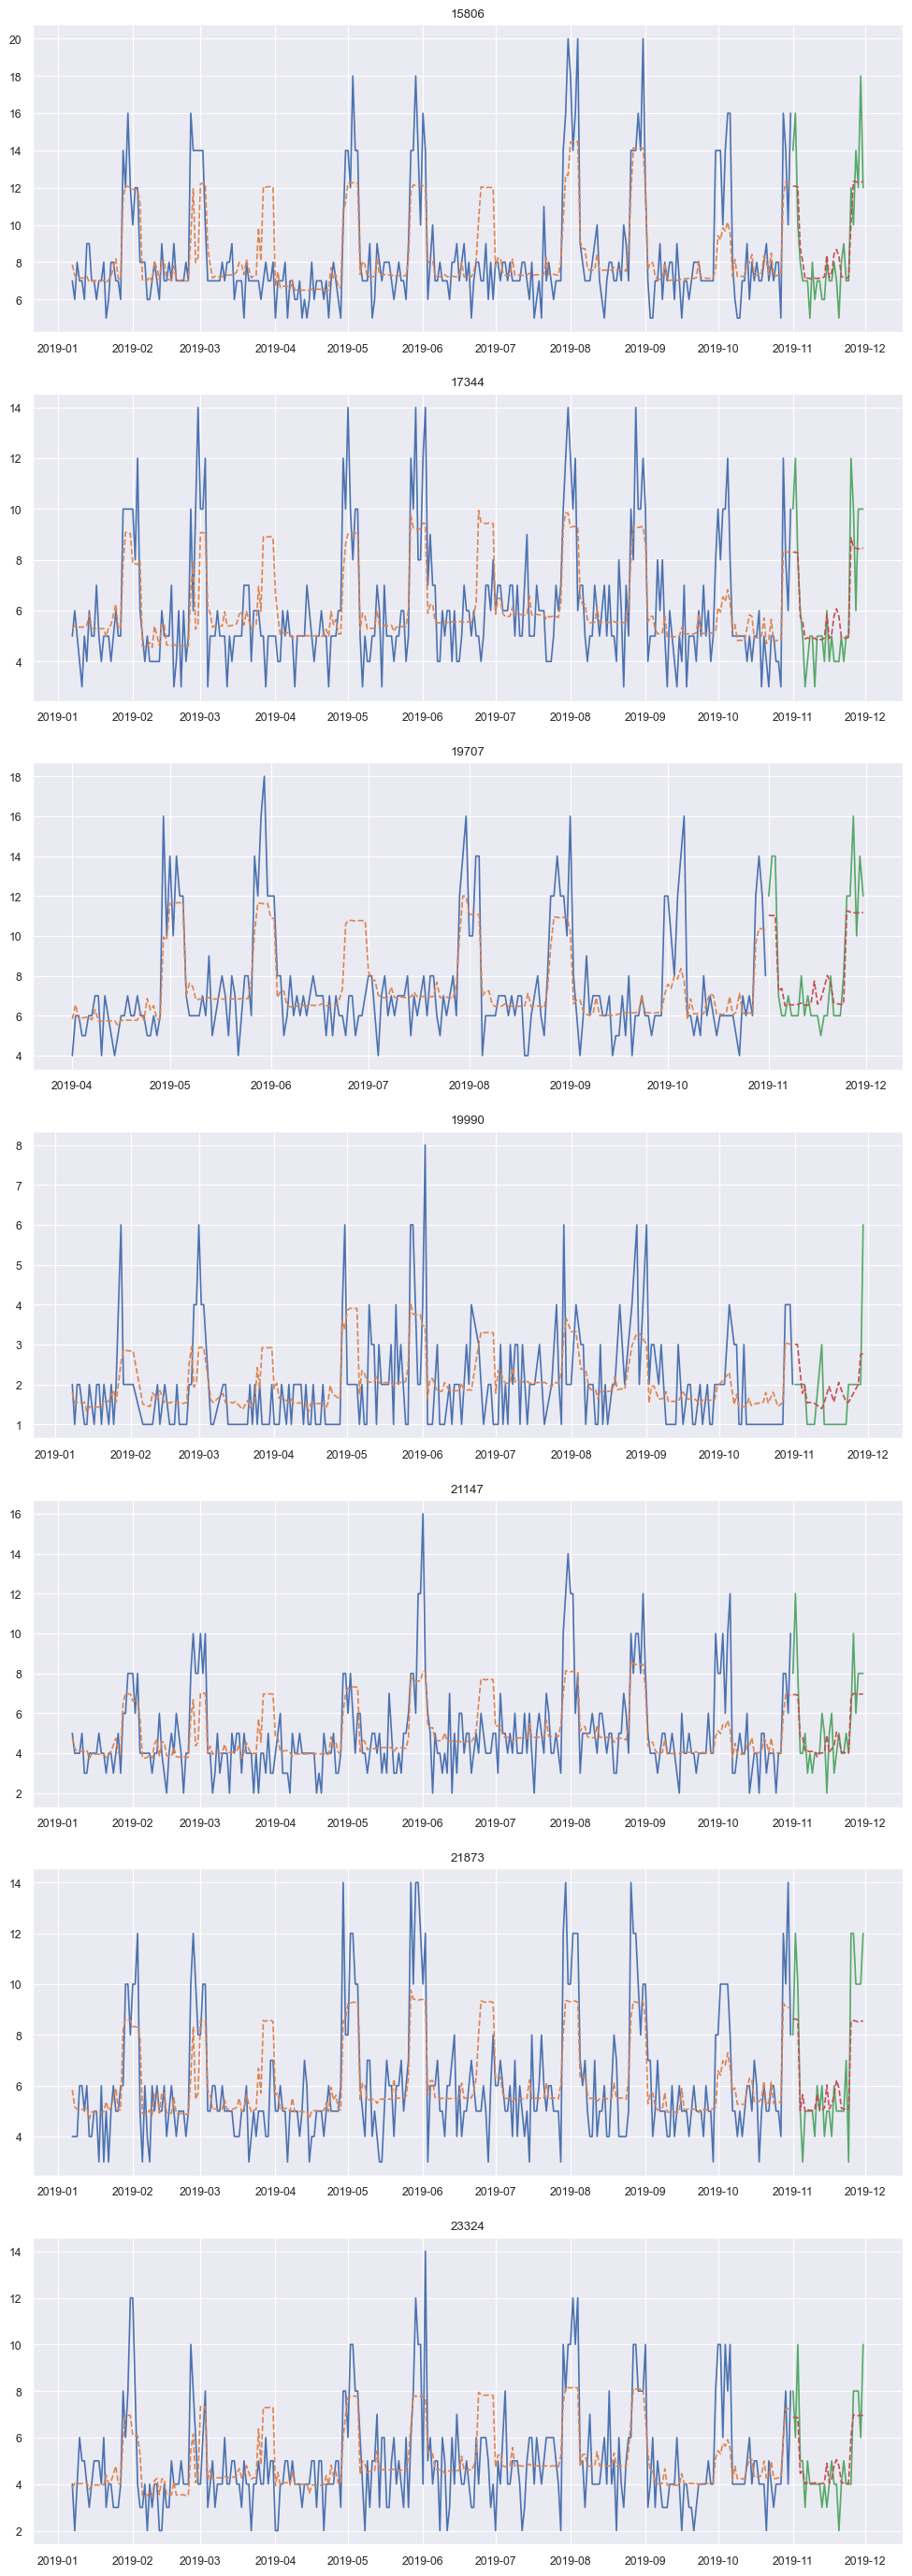

In [167]:
class_ = 'class_3'

data = catboost.Pool(train_df.loc[:, features[class_]],
    cat_features=cat_features)

data = catboost.Pool(train_df.loc[:, features[class_]],
                     cat_features=cat_features)
pred = models[class_].predict(data)
res_all = pd.DataFrame([train_df.SKU.values, train_df.dates.values, train_df.sales.values, pred], 
                   index=['SKU', 'dates', 'sales', 'pred']).T


data = catboost.Pool(val_df.loc[:, features[class_]],
                     cat_features=cat_features)

pred = models[class_].predict(data)
res_pred = pd.DataFrame([val_df.SKU.values, val_df.dates.values, val_df.sales.values, pred], 
                   index=['SKU', 'dates', 'sales', 'pred']).T

n = 7
fig, ax = plt.subplots(n, 1, figsize=(12, 5*n))
for i, sku in enumerate(list(sku_classes[class_][:n])):
    
    df = res_all[res_all['SKU']==sku].sort_values('dates')
    ax[i].plot(df.dates, df.sales.values)
    ax[i].plot(df.dates, df.pred.values, '--')
    
    # price = 0
    df = res_pred[res_pred['SKU']==sku].sort_values('dates')
    ax[i].plot(df.dates, df.sales.values)
    ax[i].plot(df.dates, df.pred.values, '--')
    ax[i].set_title(sku)

In [168]:
for k in models.keys():
    fname = PATH_ARTEFACTS +'/' + k + '.pkl'
    pickle.dump(models_full[k], open(fname, 'wb'))

fname = PATH_ARTEFACTS +'/features.json'
with open(fname, 'w') as outfile:
    json.dump(features, outfile)

# <a id="po">Price optimisation</a>

In [169]:
from scipy.optimize import minimize
from skopt import gp_minimize

In [172]:
with open(PATH_ARTEFACTS + '/features.json', 'r') as json_file:
    features = json.load(json_file)

models = {}
for k in features.keys():
    fname = PATH_ARTEFACTS +'/' + k + '.pkl'
    models[k] = pickle.load(open(fname, 'rb'))
    
with open(PATH_ARTEFACTS +'/sku_classes.json', 'r') as json_file:
    sku_classes = json.load(json_file)

For the low variance class the model has no dependence on the price, only on price diff.

### profit optimization

I try to determinal optimal 4 week price vector for each SKU, by solving 4d optimisation problem.

In [292]:
daily_pred.loc[daily_pred[daily_pred.day==1].index, 'week_num'] = 101

In [321]:
class Objectiv:
    def __init__(self, models, features):
        self.models = models
        self.features_dict = features
        self.cat_features = ['weekday', 'brand_code', 'SKU']
        self.target_weeks = [100, 101, 102, 103, 104]
    
    def set_prices(self, price):
        price = [self.df.price_avg.values[0]] + price
        price_week_df = pd.DataFrame([target_weeks, price], index=['week_num', 'price_week']).T
        price_week_df['price_week_diff'] = price_week_df.price_week.diff(1)
        price_week_df['week_num'] = price_week_df['week_num'].astype(int)
        price_week_df = price_week_df.iloc[1:, :]

        price_vector = 8*[price[1]] + 7*[price[2]] + 7*[price[3]] + 7*[price[4]]
        
        df = self.df.iloc[-29:, :]
        df = df.merge(price_week_df.loc[:, ['week_num', 'price_week_diff']], 
                                on='week_num', how='left')
        df['price_avg'] = price_vector
        return df
        
    def set_objectiv(self, class_, df):
        self.model = self.models[class_]
        self.df = df
        self.features = self.features_dict[class_]
        
    def predict(self, price):
        df = self.set_prices(price)
        df['avg_price_ratio'] = df['price_avg']/df['cost_price']
        df['price_diff'] = df['price_avg'].diff(1)
        X = df.loc[:, self.features]
        pool_X = catboost.Pool(X,
                               cat_features=self.cat_features)
        
        df['sales'] = self.model.predict(pool_X) 
        return -(df['price_avg']*df['sales']).sum()
        
objectiv = Objectiv(models, features)

In [323]:
daily_data = daily_data.sort_values('dates')
price_range = daily_data.groupby('SKU').agg(p_min=('price_avg', lambda x: x.quantile(q=0.01)),
                                            p_mean=('price_avg', 'mean'),
                                            p_last=('price_avg', 'last'),
                                            p_max=('price_avg', lambda x: x.quantile(q=0.99)))

reverse_class_mapper = {}
for k in sku_classes.keys():
    for sku in sku_classes[k]:
        reverse_class_mapper[sku] = k
        
assert set(reverse_class_mapper.keys()) == set(daily_data.SKU.unique())

In [335]:
daily_pred = daily_pred.reset_index(drop=True)
price_actions = daily_pred.loc[:, ['dates', 'SKU']]
price_actions = price_actions.reset_index(drop=True)
price_actions['class'] = np.nan
price_actions = price_actions[price_actions.dates > np.datetime64('2019-11-30')].reset_index(drop=True)

all_sku = price_actions.SKU.unique()

In [351]:
for sku in tqdm(all_sku):
    class_ = reverse_class_mapper[sku]
    if class_ != '':
        df = daily_pred[daily_pred.SKU==sku]
        objectiv.set_objectiv('high_volatility', df)
        p_range = price_range.loc[sku, :].values
        if True:
            p_opt = gp_minimize(objectiv.predict,
                                4*[(p_range[0], p_range[-1])],
                                acq_func="EI",       # the acquisition function
                                n_calls=50,          # the number of evaluations of f
                                n_random_starts=25,   # the number of random initialization points
                                ) 
        else:
            p_opt = minimize(objectiv.predict, 
                             x0=4*[p_range[1]], constraints=4*[(p_range[0], p_range[-1])], 
                             method='BFGS')
        p_star = p_opt.x[0]
    else:
        p_star = p_range[2]        
    
    ii = price_actions[price_actions.SKU==sku].index
    price_actions.loc[ii, 'base_strategy'] = p_star
    price_actions.loc[ii, 'price_mean'] = p_range[1]
    price_actions.loc[ii, 'price_min'] = p_range[0]
    price_actions.loc[ii, 'price_max'] = p_range[-1]
    price_actions.loc[ii, 'class'] = class_

100%|█████████████████████████████████████████| 826/826 [49:54<00:00,  3.63s/it]


In [352]:
price_actions.head()

,dates,SKU,class,base_strategy,price_mean,price_min,price_max
0,2019-12-01,88248,class_1,3216.832495,3215.574324,2944.0,3308.0
1,2019-12-01,78624,class_1,4156.927536,4146.559880,3768.0,4281.0
2,2019-12-01,27720,class_1,2619.789147,2733.131707,2536.0,2812.0
3,2019-12-01,63603,class_1,2911.352260,2887.652695,2652.0,2988.0
4,2019-12-01,72432,class_1,3561.855500,3558.385113,3260.0,3652.0


In [373]:
assert price_actions.drop_duplicates().shape == price_actions.shape

### price actions

In [368]:
columns = ['SKU', 'dates', 'cost_price', 'min_comp_price']
price_actions_bandits = price_actions.merge(daily_pred.loc[:, columns], on=['SKU', 'dates'], how='left')

last_two_week_price = daily[(daily.dates>np.datetime64('2019-11-16'))&(daily.dates<np.datetime64('2019-12-01'))].groupby('SKU', as_index=False).price_avg.mean()
last_two_week_price.columns = ['SKU', 'last_two_week_price'] 
price_actions_bandits = price_actions_bandits.merge(last_two_week_price, on='SKU', how='left')

last_price = daily[daily.dates<np.datetime64('2019-12-01')].groupby('SKU', as_index=False).price_avg.last().rename(columns={'price_avg': 'last_price'})
price_actions_bandits = price_actions_bandits.merge(last_price, on='SKU', how='left')

In [369]:
price_actions_bandits.head()

,dates,SKU,class,base_strategy,price_mean,price_min,price_max,cost_price,min_comp_price,last_two_week_price,last_price
0,2019-12-01,88248,class_1,3216.832495,3215.574324,2944.0,3308.0,2832.0,-999.000000,3252.923077,3228.0
1,2019-12-01,78624,class_1,4156.927536,4146.559880,3768.0,4281.0,3629.0,-999.000000,4189.285714,4246.0
2,2019-12-01,27720,class_1,2619.789147,2733.131707,2536.0,2812.0,2411.0,2657.119060,2784.153846,2749.0
3,2019-12-01,63603,class_1,2911.352260,2887.652695,2652.0,2988.0,2644.0,-999.000000,2963.500000,2988.0
4,2019-12-01,72432,class_1,3561.855500,3558.385113,3260.0,3652.0,3174.0,3621.245291,3593.428571,3587.0


In [366]:
price_actions_bandits.to_csv(PATH_ARTEFACTS + '/price_actions_optimization_30_plus.csv', sep=',', index=False)